In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import fastai
from fastai.vision import *

In [3]:
from imbalanced_sampler import ImbalancedDatasetSampler

In [4]:
path = Path('.')

In [5]:
train = path/'train_dehaze/'
test =  path/'leaderboard_test_data_dehaze/'
holdout = path/'leaderboard_holdout_data_dehaze/'
sample_sub = path/'SampleSubmission.csv'
labels = path/'traininglabels.csv'

In [6]:
test_names = [f for f in test.iterdir()]
holdout_names = [f for f in holdout.iterdir()]

In [7]:
df = pd.read_csv(labels)
df_sample = pd.read_csv(sample_sub)

In [8]:
df.head()

,image_id,has_oilpalm,score
0,img_000002017.jpg,0,0.7895
1,img_000012017.jpg,0,1.0000
2,img_000022017.jpg,0,1.0000
3,img_000072017.jpg,0,1.0000
4,img_000082017.jpg,0,1.0000


In [9]:
(df.has_oilpalm==1).sum()

942

In [40]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=2):
        super().__init__()
        self.gamma = gamma
        
    def forward(self, input, target):
        input = input[:,1].sigmoid()
        target = target.float()
        max_val = (-input).clamp(min=0)
        loss = input - input * target + max_val + \
            ((-max_val).exp() + (-input - max_val).exp()).log()

        invprobs = F.logsigmoid(-input * (target * 2.0 - 1.0))
        loss = (invprobs * self.gamma).exp() * loss
        
        return loss.sum()

In [42]:
def get_data(size=128, bs=64, pct=0.2, seed=2019, n_sample=len(df)):
    data = (ImageItemList.from_df(df.sample(n_sample), path, folder=train)
           .random_split_by_pct(pct, seed=seed)
           .label_from_df('has_oilpalm')
           .add_test(test_names+holdout_names)
           .transform(get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.), size=size))
    
    test_ds = data.test
    train_ds, val_ds = data.train, data.valid
    datasets = [train_ds,val_ds, test_ds]
    sampler = ImbalancedDatasetSampler(datasets[0], func=np.log)
    train_dl = DataLoader(datasets[0], bs, sampler=sampler, num_workers=12)
    val_dl = DataLoader(datasets[1], 2*bs, False, num_workers=8)
    test_dl = DataLoader(datasets[2], 2*bs, False, num_workers=8)

    return ImageDataBunch(train_dl=train_dl, valid_dl=val_dl, test_dl=test_dl).normalize(imagenet_stats)

In [62]:
#This was working perfectly some minutes ago!
from sklearn.metrics import roc_auc_score
def auc_score(y_score,y_true):
    return torch.tensor(roc_auc_score(y_true,y_score[:,1])) # use as metric

def get_learner(data, mixup=True, fp16=True):
    learn = create_cnn(data, 
                       models.resnet50,
                       pretrained=True,
#                        loss_func=FocalLoss(),
                       metrics=[accuracy])
    if mixup: learn.mixup()
    if fp16: return learn.to_fp16()
    else: return learn

In [50]:
%pdb

Automatic pdb calling has been turned ON


In [63]:
data = get_data(256, 64)

In [64]:
learn = get_learner(data)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.torch/models/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:32<00:00, 3131811.73it/s]


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.29E-02


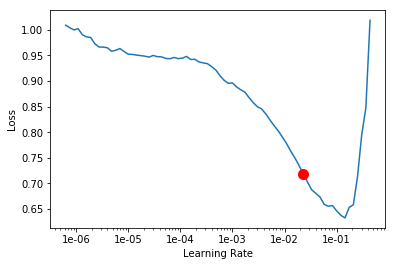

In [65]:
learn.lr_find(); learn.recorder.plot()

In [67]:
lr = 1e-2

256

In [68]:
learn.fit_one_cycle(6, lr)
learn.save('256')

epoch,train_loss,valid_loss,accuracy
1,0.173777,0.040424,0.989501
2,0.145388,0.037072,0.992454
3,0.141268,0.077284,0.983596
4,0.131808,0.035193,0.992454
5,0.126709,0.036145,0.993110
6,0.113149,0.037887,0.992782


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.98E-06


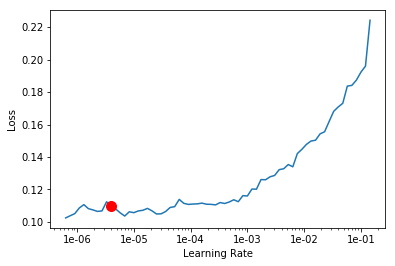

In [69]:
learn.unfreeze()
learn.lr_find(); learn.recorder.plot()

In [70]:
learn.fit_one_cycle(6, slice(1e-6,1e-4))
learn.save('256u')

epoch,train_loss,valid_loss,accuracy
1,0.121333,0.032802,0.993766
2,0.107019,0.033995,0.993110
3,0.107742,0.033816,0.993110
4,0.104877,0.034077,0.993110
5,0.112646,0.033834,0.993110
6,0.107106,0.032798,0.994094


Results

In [80]:
learn = get_learner(data, mixup=False)
learn.load('256u')
interp = ClassificationInterpretation.from_learner(learn, DatasetType.Train)

In [90]:
losses, idxs = interp.top_losses(83); idxs

tensor([ 1462,  6261,  2848,  1549, 11256, 12045, 10968,  6640,  4415,  1257,
         1111,  3069,  8764,  5035,  6198, 11543,  7512,  6512,  9194,  7415,
         8376,   887,  9341, 11738,  1613,  9803,  5962,  3882, 11295,  8488,
         7199,  9377, 11851,  5143,  8337,  4594,  3897,  7549,  9408, 10279,
          220,   227,  4279, 11622, 10202,  5308,  8096, 11215,  8909,  5382,
         9251, 10014,  6571,  2497,  6669,  4671,  4837,  6172,  6427,  9640,
         2363,  1472, 10933, 10920,   152,  4215,   165,  5764,  4730,  7439,
         5244,  4188,  9150,  7925,  7748,  1545, 11884, 11489,  3497,  4716,
         4603,  8415,  1610])

[(1, 0, 73), (0, 1, 10)]

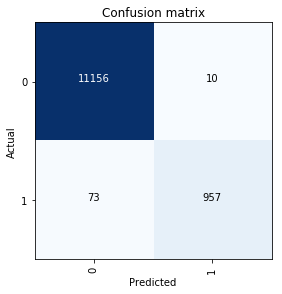

In [110]:
interp.plot_confusion_matrix()
interp.most_confused()

In [109]:
interp_val = ClassificationInterpretation.from_learner(learn)
interp_train = ClassificationInterpretation.from_learner(learn, DatasetType.Train)
fn, fp = interp_val.most_confused()
n1 = fn[2]+fp[2]
fn, fp = interp_train.most_confused()
n2 = fn[2]+fp[2]
print(f'Hard images count : {n1+n2}')
losses, idxs_val = interp_val.top_losses(int(n1))
losses, idxs_train = interp_train.top_losses(int(n2))

hard_images_val = data.valid_ds.items[idxs_val]
hard_images_train = data.train_ds.items[idxs_train]

hard_images_names = [f[-17:] for f in hard_images_train] + [f[-17:] for f in hard_images_val]; hard_images_names[0:3]

Hard images count : 78


['img_110252018.jpg', 'img_012962018.jpg', 'img_037892018.jpg']

In [111]:
df2 = df.set_index('image_id')
df2.loc[hard_images_names]

,has_oilpalm,score
image_id,,
img_110252018.jpg,0,1.0000
img_012962018.jpg,0,1.0000
img_037892018.jpg,0,1.0000
img_077932017.jpg,0,0.5916
img_085862018.jpg,0,1.0000
img_087612017.jpg,0,1.0000
img_012102017.jpg,0,1.0000
img_062472018.jpg,0,1.0000
img_005012018.jpg,0,0.8189


## Sub file

In [16]:
ids = np.array([f.name for f in test_names]+[f.name for f in holdout_names])

In [17]:
ids.shape

(6534,)

In [18]:
sub = pd.DataFrame(np.stack([ids, preds], axis=1), columns=df_sample.columns)

In [19]:
sub.to_csv('sub_resneXt101x5_haze_TTA.csv', index=False)

In [24]:
sub.has_oilpalm.asdtype(float)

AttributeError: 'Series' object has no attribute 'asdtype'